# **🐍 Improving Reinforcement Learning using Actor Critic Methods 🤖**

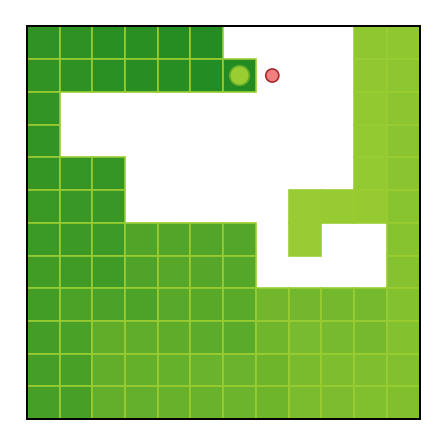

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2025/blob/main/practicals/Reinforcement_Learning/Part_1/Solving_the_Snake_game_using_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2025. Apache License 2.0.

**Authors:** Siddarth Singh, Sasha Abramowitz, Ruan de Kock, Matthew Morris, Miruna Pîslar

**Introduction:**

Welcome to the second session of the RL practical! We are going to be improving on our previously written Reinforcement Learning algorithm (**REINFORCE**) to better solve the game of Snake.

Our approach will rely on learning a function to estimate the return, referred to as a **baseline**. This will reduce the variance of our policy, improving model performance.
Our end goal is to implement the Advantage Actor-Critic (A2C) reinforcement learning algorithm.

**Learning Objectives:**

By the end of this practical, you will be able to:

*   ✅ **Understand** bias and variance, and the issues REINFORCE has with high variance.
*   🎲 **Discover** how a baseline can be used to reduce the variance of REINFORCE.
*   📈 **Build** an intuitive understanding of how baselines can be learned, and computed using *advantage estimation*.
*   🚀 **Implement** a commonly used RL algorithm, A2C, which is an improvement upon REINFORCE using a learned baseline.

**Prerequisites:**

To get the most out of this tutorial, you should have some familiarity with:

* [Python](https://www.python.org/) and common libraries like [numpy](https://numpy.org/)
* [JAX](https://github.com/google/jax) for fast, numerical computing and automatic differentiation
* Basic Machine Learning concepts, such as model parameters (weights), gradients, and the softmax function
* [Session 1 of the RL practical](https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2025/blob/main/practicals/Reinforcement_Learning/Part_1/Solving_the_Snake_game_using_RL.ipynb)



In [ ]:
# @title Install and import required packages (Run me)

%%capture
!pip install jumanji

from typing import NamedTuple

import jumanji
from jumanji.wrappers import JumanjiToGymWrapper
from jumanji.environments.routing.snake.types import Actions, State, Observation
import gymnasium as gym

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import flax.linen as nn
import optax

import matplotlib.pyplot as plt
import numpy as np
import imageio
from IPython.display import display, Image
import io

from tqdm import notebook


### Helper and Utility Functions
We will also use all the helper functions we defined in the previous practical, without going over them again.

In [ ]:
# @title Utilities (Run me)

# Environment wrapper
class SnakeWrapper(JumanjiToGymWrapper):
  def __init__(self, env):
    super().__init__(env)
    # Flatten the grid observation for simplicity
    self.observation_space["grid"] = gym.spaces.flatten_space(self.observation_space["grid"])

  def reset(self):
    obs, info = super().reset()
    obs["grid"] = obs["grid"].reshape(-1)  # Flatten the grid observation for simplicity
    return obs, info

  def step(self, action):
    obs, reward, term, trunc, info = super().step(action)
    obs["grid"] = obs["grid"].reshape(-1)  # Flatten the grid observation for simplicity

    # This is a simplicifaction for this tutorial, we use the old Gym API for ease
    # of explaination. For a good discussion around the difference between
    # termination and truncation see:
    # https://farama.org/Gymnasium-Terminated-Truncated-Step-API
    done = term or trunc
    return obs, reward, done, info

# Environment setup
GRID_SIZE = 4  # how big our grid will be
key = jax.random.PRNGKey(42)  # random seed

env = jumanji.make("Snake-v1", num_rows=GRID_SIZE, num_cols=GRID_SIZE)
env = SnakeWrapper(env)  # A friendly environment API

# Environment variables
num_actions = int(env.action_space.n)
observation_shape = env.observation_space['grid'].shape

# Action masking
def mask_illegal_actions(logits, action_mask, negative_action_value=-9999999):
  masked_logits = jnp.where(action_mask, logits, negative_action_value)
  return masked_logits

# Logits to probabilities
def get_action_probabilities(logits):
  return jnp.exp(logits) / jnp.sum(jnp.exp(logits))

# Action sampling
def sample_action(logits, key):
  action_probabilities = get_action_probabilities(logits)
  action = jax.random.choice(
      key, jnp.array([0, 1, 2, 3]), p=action_probabilities
    )
  return action

def select_action(logits, key):
    """Sample an action from the policy distribution."""
    # jax.random.categorical works directly on logits
    return jax.random.categorical(key, logits)

# Policy network
class PolicyNetwork(nn.Module):
  def setup(self):
    self.layer_1 = nn.Dense(16)
    self.layer_2 = nn.Dense(16)
    self.output_layer = nn.Dense(4)

  def __call__(self, observation):
    hidden = self.layer_1(observation)
    hidden = jax.nn.relu(hidden)
    hidden = self.layer_2(observation)
    hidden = jax.nn.relu(hidden)
    logits = self.output_layer(hidden)

    return logits

# Discounted return
def compute_discounted_return(rewards, discount_factor=0.99):
    returns = []
    cumulative_return = 0.0

    # Work backwards through the rewards
    for r in reversed(rewards):
        cumulative_return = r + discount_factor * cumulative_return
        returns.append(cumulative_return)

    # Reverse to get forward chronological order
    returns.reverse()
    return jnp.array(returns)

# Batched policy application
policy_network = PolicyNetwork()
batched_policy_apply = jax.vmap(policy_network.apply, in_axes=(None, 0))

# Log probabilities
def get_action_log_prob(logits, action):
  action_probabilities = get_action_probabilities(logits)
  action_log_prob = jnp.log(action_probabilities[action])
  return action_log_prob

# Batched action probabilities
batched_get_action_log_prob = jax.vmap(get_action_log_prob, in_axes=(0, 0))

# Batched objective function
def batched_reinforce_loss_function(policy_params, observations, actions, discounted_returns):
  batch_logits = batched_policy_apply(policy_params, observations)
  batch_action_log_probabilities = batched_get_action_log_prob(batch_logits, actions)
  reinforce_objective_value = reinforce_objective(batch_action_log_probabilities, discounted_returns)

  return reinforce_objective_value

## 0. Recap of REINFORCE

To recap what we covered in the previous practical:
1. ⚙️ We did a brief overview of reinforcement learning as a whole.
2. 🔧 We saw rule-based policies in action.
3. 🔋 We showed how policies could be parameterised.
4. 🤖 We used Neural Networks as policies.
5. 📈 We derived the gradient of a policy, which we can use to update the parameters.
6. 🖥️ We implemented the **REINFORCE** algorithm.

REINFORCE is the canonical example of a *policy gradient method*, and most other methods are built on top of it.
The goal of policy gradient methods is to learn a policy $\pi$ that (1) takes in observations from the environment and then (2) returns the action that maximises the reward the agent obtains.

Recall that our REINFORCE gradient is defined as follows, which we use to "climb the mountain" and update our policy parameters to increase the reward:

$$\nabla_\theta J(\theta)
\propto \mathbb{E}_{\pi_\theta} \left[ Q^\pi(s, a) \, \nabla_\theta \log \pi_\theta(a \mid s) \right] = \mathbb{E}_{\pi_\theta} \left[ G_t \, \nabla_\theta \log \pi_\theta(A_t \mid S_t) \right],$$

where $A_t$ is the agent action at time step $t$, $S_t$ is the state at $t$, and $G_t$ is the return from $t$ onwards.

$A_t, S_t, G_t$ are sampled by repeatedly rolling out the agent in the environment.
In our code, we thus define the following objective function, where $G_t$ = `discounted_returns` and $\log \pi_\theta(A_t \mid S_t)$ = `action_log_probs`.

In [ ]:
# Reinforce objective function
def reinforce_objective(action_log_probs, discounted_returns):
  objective = -(discounted_returns * action_log_probs)
  return jnp.mean(objective)

### Training Loop

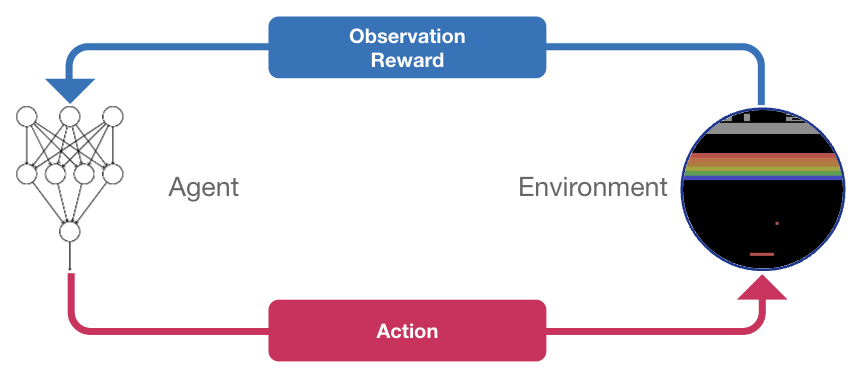

This is the training loop as it stands: we will be improving on this during the practical.

The process is:
1. Randomly initialise the network parameters
2. Start the agent-environment loop. Repeat a specified number of times.
    1. Gather experience for an entire episode.
    2. Compute discounted return from the rewards.
    3. Use the return to update the policy.
    4. Repeat.

In [ ]:
total_num_episodes = 21 # Make this larger if you want the model to train for longer

# 1. Initialise the network and parameters
policy_network = PolicyNetwork()
dummy_obs = jnp.ones(observation_shape)
key, network_init_key = jax.random.split(key)
policy_params = policy_network.init(network_init_key, dummy_obs)

# Jit everything
jit_policy_network_apply = jax.jit(policy_network.apply)
jit_mask_illegal_actions = jax.jit(mask_illegal_actions)
jit_sample_action = jax.jit(sample_action)

# Create the optimiser
optim = optax.adam(learning_rate=5e-4)

# Initialise the optimiser state
opt_state = optim.init(policy_params)

# 2. Agent-environment loop
# Here is our termination critieria. Train for only a fixed number of episodes.
for episode in range(total_num_episodes):
  # Create a way to store the agent's experience it gathers while interacting
  # in the environment.
  rewards = []
  observations = []
  actions = []

  # Reset the environment and set the return to zero so we can measure our
  # agent's performance.
  episode_return = 0
  obs, info = env.reset()
  done = False

  # 2.1 Gather experience for an entire episode.
  while not done:
    grid_obs = obs['grid']
    logits = jit_policy_network_apply(policy_params, grid_obs)

    action_mask = obs['action_mask']
    logits = jit_mask_illegal_actions(logits, action_mask, jnp.finfo(jnp.float32).min)

    key, action_key = jax.random.split(key)
    action = jit_sample_action(logits, action_key)

    # store the observation and action taken for training
    observations.append(grid_obs)
    actions.append(action)

    # step the evironment
    obs, reward, done, info = env.step(action)

    # store the reward for training
    rewards.append(reward)

    episode_return += reward # increment the return

  # Only print the reward every 10 episodes
  if episode % 10 == 0:
    print(f"Episode {episode}: Return: {episode_return}")

  # 2.2 After gathering an episode's experience, compute discounted return from the rewards
  discounted_returns = compute_discounted_return(rewards)

  # Convert data to jax.numpy arrays.
  observations = jnp.array(observations)
  actions = jnp.array(actions)

  # 2.3 update the policy
  gradients = jax.grad(batched_reinforce_loss_function)(policy_params, observations, actions, discounted_returns)
  updates, new_opt_state = optim.update(gradients, opt_state)
  params = optax.apply_updates(policy_params, updates)
  opt_state = new_opt_state

  # 2.4 Repeat!

Episode 0: Return: 7.0
Episode 10: Return: 8.0
Episode 20: Return: 4.0


## 1. The Limitations of REINFORCE

REINFORCE relies on computing an expectation of the gradient by sampling:

$$\nabla_\theta J(\theta)
\propto \mathbb{E}_{\pi_\theta} \left[ G_t \, \nabla_\theta \log \pi_\theta(A_t \mid S_t) \right].$$

Thus, this method is only as good as the expectation is at approximating the true gradient.
Let's start with a simple experiment.

We will fix the parameters of our agent (instead of updating them during training) and just compute the size of the gradient over a number of episodes.
I.e. in each episode, $\theta$ is the same, so we should expect to see a similar estimate for $\nabla_\theta J(\theta)$ in each episode, if our REINFORCE expectation is doing its job!

Let's run a simulation and see what happens.

In [ ]:
# @title Run Simulation

num_episodes_in_simulation = 20

# Store gradient norms over episodes
gradient_norms = []

for episode in notebook.tqdm(range(num_episodes_in_simulation)):
    rewards = []
    observations = []
    actions = []

    episode_return = 0
    obs, info = env.reset()
    done = False

    while not done:
        grid_obs = obs['grid']
        logits = jit_policy_network_apply(policy_params, grid_obs)

        action_mask = obs['action_mask']
        logits = jit_mask_illegal_actions(logits, action_mask, jnp.finfo(jnp.float32).min)

        key, action_key = jax.random.split(key)
        action = jit_sample_action(logits, action_key)

        observations.append(grid_obs)
        actions.append(action)

        obs, reward, done, info = env.step(action)
        rewards.append(reward)
        episode_return += reward

    discounted_returns = compute_discounted_return(rewards)
    observations = jnp.array(observations)
    actions = jnp.array(actions)

    # Compute gradients
    gradients = jax.grad(batched_reinforce_loss_function)(policy_params, observations, actions, discounted_returns)

    # Flatten all gradients into a single vector and compute norm
    def flatten_and_concatenate(tree):
        return jnp.concatenate([jnp.ravel(x) for x in jax.tree_util.tree_leaves(tree)])

    grad_vector = flatten_and_concatenate(gradients)
    grad_norm = jnp.linalg.norm(grad_vector) # Frobenius norm
    gradient_norms.append(float(grad_norm))

# Plot gradient norms over episodes
plt.plot(range(num_episodes_in_simulation), gradient_norms)
plt.xlabel("Episode")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm Over Episodes")
plt.grid(True)
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

NameError: name 'jit_policy_network_apply' is not defined

Notice how much the graph jumps up and down: this is not a good sign.

This means that our estimator of the gradient has **high variance**.
If our estimate of the gradient is off, it will impede the training of the model or, even worse, make the model worse!

How do we solve this? 🤔

One naive solution may be to compute the gradient over a number episodes, using the same parameters $\theta$, then **compute the average gradient** and use it to update the parameters.
This would work, since the more you sample, the lower the overall variance will be and the closer the estimation will be to the true gradient.
We saw this in the previous practical with the example of rolling dice - the more you roll the dice, the closer the average value will become to the true average of 3.5.

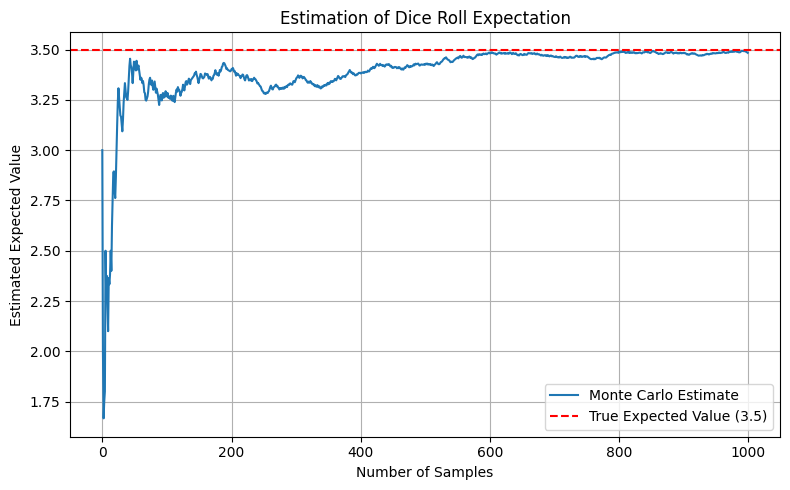

In [ ]:
#@title Dice Rolling, Expectation as Samples Increases (run me)

import numpy as np
import matplotlib.pyplot as plt

# --- Ground truth expected value of a fair 6-sided die
true_value = np.mean([1, 2, 3, 4, 5, 6])

# --- Monte Carlo sampling
n_samples = 1000
samples = np.random.randint(1, 7, size=n_samples)  # simulate die rolls
estimates = np.cumsum(samples) / (np.arange(n_samples) + 1)  # running average

# --- Plot convergence
plt.figure(figsize=(8, 5))
plt.plot(estimates, label='Monte Carlo Estimate')
plt.axhline(true_value, color='red', linestyle='--', label='True Expected Value (3.5)')
plt.xlabel('Number of Samples')
plt.ylabel('Estimated Expected Value')
plt.title('Estimation of Dice Roll Expectation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


However, this is not a good solution by itself, since we would have to roll out our agent many times in the environment before each gradient update, slowing down our model.

> In the next section, we will see a much neater way to reduce the variance in the REINFORCE estimator, using a **baseline**.

Another issue with REINFORCE is that we have to complete an entire environment loop every time before updating the agent parameters: what if instead we had a way to estimate the return midway through an episode? 👀 This is referred to as a **partial rollout**.

> We will also see how to do this later in the prac, using **critics** and **bootstrapping**.

## 2. Reducing the Variance

The key idea to reduce this variance is to subtract a **baseline** $b(S_t)$ from the return $G_t$. The baseline can be any function that depends on the state $S_t$, but **not** on the action $A_t$.

### Advantage Estimations with Monte Carlo Returns


As we've seen, we can make our gradient estimate more stable by using a **baseline**. A great choice for the baseline is the **state-value function**, $V^\pi(s) = \mathbb{E}_{\pi_\theta} [G_t \mid S_t = s]$. This function tells us the expected return we'll get starting from state $s$ and following our policy $\pi$.

$$V^\pi(s) = \mathbb{E}_{\pi_\theta} [G_t \mid S_t = s]$$

This changes our update rule from:

$$\nabla_\theta J(\theta) \propto \mathbb{E}_{\pi_\theta} \left[ \color{red}{G_t} \, \nabla_\theta \log \pi_\theta(A_t \mid S_t) \right]$$

to:

$$\nabla_\theta J(\theta) \propto \mathbb{E}_{\pi_\theta} \left[ \color{blue}{(G_t - V^\pi(s))} \, \nabla_\theta \log \pi_\theta(A_t \mid S_t) \right]$$

This quantity, $\color{blue}{G_t - V^\pi(S_t)}$, is so important that it has its own name: the **advantage**, $A^\pi$<sup><a href="#footnote1">1</a></sup>. In plain words, it is the difference between the realized return and the state's value estimate.

> Intuitively, the advantage tells us if the agent acted better than expected:
> - If $A_t > 0$, i.e., $G_t > V^\pi(S_t)$: the agent action was better than expected → increase its likelihood.
> - If $A_t < 0$, i.e., $G_t < V^\pi(S_t)$: the agent action was worse than expected → decrease its likelihood.

Our gradient update is now:
$$\nabla_\theta J(\theta)
\propto \mathbb{E}_{\pi_\theta} \left[ \color{blue}{A^\pi(S_t, A_t)} \, \nabla_\theta \log \pi_\theta(A_t \mid S_t) \right]$$


The Advantage Function provides a solution by changing the question. Instead of asking, "Was the outcome good?", we ask, "Was the outcome better than we expected it to be?"

This provides a much more stable and focused learning signal. It centers the rewards around zero, helping the agent distinguish between "bad" and "less bad" actions, or "good" and "very good" actions.

---
<p id="footnote1"><sup>1</sup> <strong>Formal definition</strong>: Formally, the Advantage Function is defined as $A^\pi(s, a) = Q^\pi(s, a) - V^\pi(s)$. The term $Q^\pi(s, a)$ is the action-value function, representing the expected return for taking action $a$ in state $s$ and then following policy $\pi$. In our Monte Carlo setting, the single observed return $G_t$ is used as an unbiased estimate of $Q^\pi(S_t, A_t)$, which makes $G_t - V^\pi(S_t)$ our practical estimate of the true advantage.</p>

### Estimating the advantage

In practice, we don't know the true value function $V^\pi(s)$. But we can estimate it from an episode's worth of data using a **Monte Carlo** approach. To get our advantage estimate, we need to compare the return we *actually got* against a baseline of what we *expected*.

1.  **Estimate the return for taking action $a_t$**: We use the actual discounted return we observed from that point onwards, $G_t$. This serves as our proxy for the specific value of taking that action in that state.
2.  **Estimate the baseline value of state $s_t$**: This is the trickiest part. A simple (though imperfect) baseline is the **mean of all the discounted returns** calculated during that episode. It's like saying, "On average, this episode was worth *X* points, so we'll use that as our baseline for every state."

So, our practical, Monte Carlo advantage estimate for a given timestep $t$ becomes:

$$A_t \approx G_t - \text{mean}(G)$$

This simple change is the first step towards a family of more advanced algorithms called **Actor-Critic** methods.

### ✏️ **Exercise: compute advantages**

Let's use the returns to compute the Monte Carlo advantage for each step.

<details>
<summary>

❓ **Hints (expand if you are stuck)** ❓

</summary>

* You’ve already computed the **discounted return** `G_t` for each timestep using `compute_discounted_return`.
* A **baseline** is a value we subtract from the return to reduce variance — in this case, we’ll use the **mean of all discounted returns**.
* The **advantage** is defined as `A_t = G_t - baseline`. This gives us a relative measure of how good a return is compared to the average.

</details>

In [ ]:
def compute_mc_advantages(rewards: list[float], discount_factor: float) -> tuple[np.ndarray, np.ndarray, float]:
    """
    Calculates the advantage A_t for each timestep using Monte Carlo estimates.

    Args:
        rewards: A list of rewards obtained during the episode.
        discount_factor: The discount factor gamma.

    Returns:
        Tuple of:
            - np.ndarray: Array where each element i is the advantage A_i.
            - np.ndarray: The discounted returns G_t for each timestep.
            - float: The baseline (mean of all discounted returns).
    """
    # 1. First, calculate the discounted return G_t for every step.
    discounted_returns = compute_discounted_return(rewards, discount_factor)

    # --- YOUR CODE HERE ---
    # 2. Calculate the baseline.
    # baseline = ...

    # 3. Calculate the advantages.
    # advantages = ...
    # ----------------------

    return advantages, discounted_returns, baseline

In [ ]:
#@title Solution

def compute_mc_advantages(rewards: list[float], discount_factor: float) -> tuple[np.ndarray, np.ndarray, float]:
    """
    Calculates the advantage A_t for each timestep using Monte Carlo estimates.

    Args:
        rewards: A list of rewards obtained during the episode.
        discount_factor: The discount factor gamma.

    Returns:
        Tuple of:
            - np.ndarray: Array where each element i is the advantage A_i.
            - np.ndarray: The discounted returns G_t for each timestep.
            - float: The baseline (mean of all discounted returns).
    """
    # 1. First, calculate the discounted return G_t for every step.
    discounted_returns = compute_discounted_return(rewards, discount_factor)

    # 2. Calculate the baseline.
    baseline = np.mean(discounted_returns)

    # 3. Calculate the advantages.
    advantages = discounted_returns - baseline

    return advantages, discounted_returns, baseline

In [ ]:
# @title Example usage (run cell and read through the output).

# Imagine an episode in a simple game with the following rewards:
# Step 0: Agent moves, gets reward -1.
# Step 1: Agent moves, gets reward -1.
# Step 2: Agent finds food, gets reward +10.
# Step 3: Agent hits a wall and episode ends, gets reward -5.
rewards_from_episode = [-1.0, -1.0, 10.0, -5.0]

# Calculate the advantages for this episode.
advantages, returns, baseline_value = compute_mc_advantages(rewards_from_episode, discount_factor=1.0)

print("--- Advantage calculation breakdown ---")
print(f"Original rewards:         {np.array(rewards_from_episode)}")
print("-" * 35)

print(f"Discounted returns (G_t): {returns}")
print(f"Baseline (mean of G_t):   {baseline_value}")
print(f"Advantages (G_t - V):     {advantages}")
print("-" * 35)

print("\n--- Interpretation ---")
print(f"The action at Step 2 led to a return of {returns[2]:.2f}, which is much higher than the average return of {baseline_value}.")
print(f"Therefore, it gets a large positive advantage of {advantages[2]}, strongly reinforcing that action.")
print(f"Conversely, the action at Step 3 led to a low return, resulting in a negative advantage of {advantages[3]}.")

--- Advantage calculation breakdown ---
Original rewards:         [-1. -1. 10. -5.]
-----------------------------------
Discounted returns (G_t): [ 3.  4.  5. -5.]
Baseline (mean of G_t):   1.75
Advantages (G_t - V):     [ 1.25  2.25  3.25 -6.75]
-----------------------------------

--- Interpretation ---
The action at Step 2 led to a return of 5.00, which is much higher than the average return of 1.75.
Therefore, it gets a large positive advantage of 3.25, strongly reinforcing that action.
Conversely, the action at Step 3 led to a low return, resulting in a negative advantage of -6.75.


### Updating the objective function

Now that we have a way to compute advantages, we need to update our objective function to use them instead of the raw discounted returns.

The old REINFORCE objective was:

`objective = -(action_log_probs * discounted_returns)`

Our new objective will be:

`objective = -(action_log_probs * advantages)`


### ✏️ **Exercise: The new advantage objective**

Fill in the `advantage_objective` function below. It's very similar to the `reinforce_objective` but uses advantages.

In [ ]:
# Implement the new objective function using advantages according to the formula above.
def advantage_objective(action_log_probs: np.ndarray, advantages: np.ndarray) -> np.ndarray:
  # --- YOUR CODE HERE ---
  # objective = ...
  # return ...
  # ----------------------

SyntaxError: incomplete input (ipython-input-2722620307.py, line 6)

In [ ]:
#@title Solution

def advantage_objective(action_log_probs: np.ndarray, advantages: np.ndarray) -> np.ndarray:
  objective = -(action_log_probs * advantages)
  objective = jnp.mean(objective)
  return objective

Now, in our training loop, we would simply replace the call to `compute_discounted_return` with a call to `compute_advantage_mc` and use our new `advantage_objective` when calculating the gradients. This single change often leads to more stable training -- see in the plot below how the variance in gradient norms changes with this simple advantage estimation addition.

  0%|          | 0/20 [00:00<?, ?it/s]

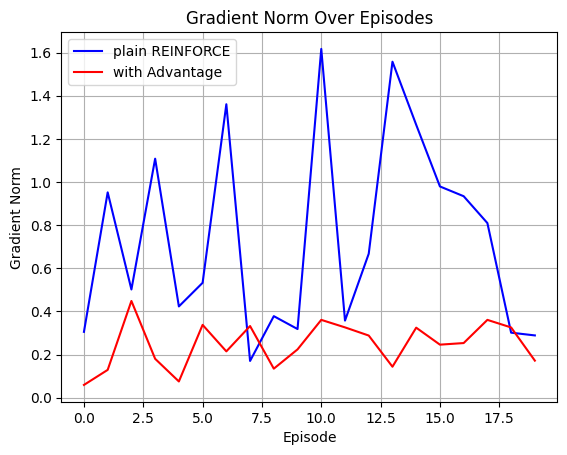

In [ ]:
#@title Run simulation and compare Advantage grad norms with REINFORCE grad norms.

# Batched objective function with advantage!
def batched_reinforce_loss_with_advantage_function(policy_params, observations, actions, advantages):
  batch_logits = batched_policy_apply(policy_params, observations)
  batch_action_log_probabilities = batched_get_action_log_prob(batch_logits, actions)
  reinforce_objective_value = advantage_objective(batch_action_log_probabilities, advantages)
  return reinforce_objective_value


num_episodes_in_simulation = 20

# Store gradient norms over episodes to comapre with REINFORCE gradient norms.
advantage_gradient_norms = []

for episode in notebook.tqdm(range(num_episodes_in_simulation)):
    rewards = []
    observations = []
    actions = []

    episode_return = 0
    obs, info = env.reset()
    done = False

    while not done:
        grid_obs = obs['grid']
        logits = jit_policy_network_apply(policy_params, grid_obs)

        action_mask = obs['action_mask']
        logits = jit_mask_illegal_actions(logits, action_mask, jnp.finfo(jnp.float32).min)

        key, action_key = jax.random.split(key)
        action = jit_sample_action(logits, action_key)

        observations.append(grid_obs)
        actions.append(action)

        obs, reward, done, info = env.step(action)
        rewards.append(reward)
        episode_return += reward

    advantages, _, _ = compute_mc_advantages(rewards, discount_factor=0.99)
    observations = jnp.array(observations)
    actions = jnp.array(actions)

    gradients = jax.grad(batched_reinforce_loss_with_advantage_function)(policy_params, observations, actions, advantages)

    def flatten_and_concatenate(tree):
        return jnp.concatenate([jnp.ravel(x) for x in jax.tree_util.tree_leaves(tree)])

    grad_vector = flatten_and_concatenate(gradients)
    grad_norm = jnp.linalg.norm(grad_vector)
    advantage_gradient_norms.append(float(grad_norm))

# Plot gradient norms over episodes
plt.plot(range(num_episodes_in_simulation), gradient_norms, color='blue', label='plain REINFORCE')
plt.plot(range(num_episodes_in_simulation), advantage_gradient_norms, color='red', label='with Advantage')
plt.xlabel("Episode")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm Over Episodes")
plt.legend(loc=0)
plt.grid(True)
plt.show()

### 🤔 Limitation of Monte Carlo Advantages

While this simple baseline is better than nothing, it's still quite basic.

1.  **Coarse-grained baseline:** It assigns the same baseline value to *every single state* in the episode. Intuitively, we know some states are inherently better than others (e.g., being close to the fruit vs. being trapped in a corner). A state-dependent baseline $b(S_t)$ would be much more powerful.
2.  **Still Monte Carlo:** We still have to wait until the end of an episode to compute our returns and advantages. This can be very inefficient, especially in environments with very long episodes. What if we could update our policy *during* an episode?

To solve these issues, we need to move beyond simple averaging. We need a way to learn a state-dependent baseline $V^\pi(s)$, and a way to update our policy without waiting for the full episode to finish. This leads us to our next topics: **learned baselines** and **bootstrapping**.

## Learned Baselines

So far we have looked at ways for us to estimate the value of the state-value function. But what if we could learn that function directly from our data?

This is exactly what is done in actor-critic methods.

An important note here, is that we need to think about what we want learn with $V^{\pi}(s)$?

### ✏️ **Exercise: What should the Value network try to learn?**

What do you think would be a suitable target from what you have previoulsy seen that the value network can try to approximate?

### Solution

Indeed, what we are attempting to learn here is the discounted future return given the current environment state. Since we don't have access to these values in RL due to non-existance of a ground truth data set, we need to build our own estimate. In this case the estimate we will use is the discounted return $G_t$ that can be expected from the current state $S_t$. Note how this is a perfect baseline to use since it is a function that depends only on $S_t$ and not $A_t$.

### Implementing a Critic network

Another advantage of taking this approach is that we are already computing the discounted return in REINFORCE. We now just need to parameterise $V^{\pi}(s)$ in a smart way and learn its optimal parameters. Thankfully, we have already seen that we can paramterise high-dimensional functions using neural networks in RL which is exactly the approach we will take here. This value network is typically referred to to as a Critic in RL for reasons we will not discuss in detail, but this is why you will see the network called a Critic network instead of a value network.

In [ ]:
# Define the critic network

class CriticNetwork(nn.Module):

  @nn.compact
  def __call__(self, observation):
      # Shared layers (already complete)
      hidden = nn.Dense(64)(observation.flatten())
      hidden = nn.relu(hidden)
      hidden = nn.Dense(64)(hidden)
      hidden = nn.relu(hidden)

      critic_value = nn.Dense(1)(hidden)

      # 2. Return the critic's value.
      # Critic's output to make it a scalar!
      return critic_value.squeeze(axis=-1)

Let's initiliased the critic network along with its parameters and an optimiser for it.

In [ ]:
critic_network = CriticNetwork()
key, critic_init_key = jax.random.split(key)
critic_params = critic_network.init(critic_init_key, dummy_obs)

critic_optim = optax.adam(learning_rate=5e-4)
critic_opt_state = critic_optim.init(critic_params)

### ✏️ **Exercise: Learnt Value Objective**

Can you think of a suitable objective function that will help the critic network slowly regress towards the critic value?

### Solution

Indeed! A perfect candidate for this is the Mean Squared Error (MSE) loss. Let's implement it.

In [ ]:
def critic_loss(predicted_discounted_returns, target_discounted_returns):

  squared_error = (predicted_discounted_returns - target_discounted_returns)**2

  return jnp.mean(squared_error)

### Use the learnt value to decrease the variance in the advantages

Aside from only defining the objective, the network and the optimiser we can now update our advantge computation function to use the new learnt value baseline.  

In [ ]:
def compute_learnt_baseline_advantages(rewards: list[float], discount_factor: float, predicted_state_values):
    """
    Calculates the advantage A_t for each timestep using Monte Carlo estimates.

    Args:
        rewards: Rewards obtained during the episode.
        discount_factor: Discount factor gamma.

    Returns:
        np.ndarray: An array where each element i is the advantage A_i.
    """
    # 1. First, calculate the discounted return G_t for every step.
    discounted_returns = compute_discounted_return(rewards, discount_factor)

    # YOUR CODE HERE
    # Use the correct baseline
    baseline = ...

    # 3. Calculate the advantage.
    advantages = discounted_returns - baseline

    return advantages, discounted_returns, baseline

### Solution

In [ ]:
def compute_learnt_baseline_advantages(rewards: list[float], discount_factor: float, predicted_state_values):
    """
    Calculates the advantage A_t for each timestep using Monte Carlo estimates.

    Args:
        rewards: Rewards obtained during the episode.
        discount_factor: Discount factor gamma.

    Returns:
        np.ndarray: An array where each element i is the advantage A_i.
    """
    # 1. First, calculate the discounted return G_t for every step.
    discounted_returns = compute_discounted_return(rewards, discount_factor)

    # 2. Use the predicted state values as the baseline
    baseline = predicted_state_values

    # 3. Calculate the advantage.
    advantages = discounted_returns - baseline

    return advantages, discounted_returns, baseline

### Compare Advantage grad norms

In [ ]:
#@title Run simulation

jit_critic_network_apply = jax.jit(critic_network.apply)
jit_critic_optim_update = jax.jit(critic_optim.update)
batched_critic_apply = jax.vmap(critic_network.apply, in_axes=(None, 0))

# Batched objective function with advantage!
def batched_reinforce_loss_with_advantage_function(policy_params, observations, actions, advantages):
  batch_logits = batched_policy_apply(policy_params, observations)
  batch_action_log_probabilities = batched_get_action_log_prob(batch_logits, actions)
  reinforce_objective_value = advantage_objective(batch_action_log_probabilities, advantages)
  return reinforce_objective_value

def batched_critic_loss(critic_params, observations, target_discounted_returns):
  batch_predicted_values = batched_critic_apply(critic_params, observations)
  critic_objective_value = critic_loss(batch_predicted_values, target_discounted_returns)
  return critic_objective_value

num_episodes_in_simulation = 20

# Store gradient norms over episodes to comapre with REINFORCE gradient norms.
learnt_value_advantage_gradient_norms = []

for episode in notebook.tqdm(range(num_episodes_in_simulation)):
    rewards = []
    observations = []
    actions = []

    # We will keep track of the values that our critic estimates.
    estimated_state_values = []

    episode_return = 0
    obs, info = env.reset()
    done = False

    while not done:
        grid_obs = obs['grid']
        logits = jit_policy_network_apply(policy_params, grid_obs)
        predicted_state_value = jit_critic_network_apply(critic_params, grid_obs)

        action_mask = obs['action_mask']
        logits = jit_mask_illegal_actions(logits, action_mask, jnp.finfo(jnp.float32).min)

        key, action_key = jax.random.split(key)
        action = jit_sample_action(logits, action_key)

        observations.append(grid_obs)
        actions.append(action)
        estimated_state_values.append(predicted_state_value)

        obs, reward, done, info = env.step(action)
        rewards.append(reward)
        episode_return += reward

    estimated_state_values = jnp.array(estimated_state_values)
    advantages, discounted_return_targets, _ = compute_learnt_baseline_advantages(rewards, discount_factor=0.99, predicted_state_values=estimated_state_values)
    observations = jnp.array(observations)
    actions = jnp.array(actions)

    # We will continually update our critic's parameters as we gather more experience to
    # learn the value function.
    critic_gradients = jax.grad(batched_critic_loss)(critic_params, observations, discounted_return_targets)
    critic_updates, critic_new_opt_state = jit_critic_optim_update(critic_gradients, critic_opt_state)
    critic_params = optax.apply_updates(critic_params, critic_updates)
    critic_opt_state = critic_new_opt_state

    gradients = jax.grad(batched_reinforce_loss_with_advantage_function)(policy_params, observations, actions, advantages)

    def flatten_and_concatenate(tree):
        return jnp.concatenate([jnp.ravel(x) for x in jax.tree_util.tree_leaves(tree)])

    grad_vector = flatten_and_concatenate(gradients)
    grad_norm = jnp.linalg.norm(grad_vector)
    learnt_value_advantage_gradient_norms.append(float(grad_norm))

# Plot gradient norms over episodes
plt.plot(range(num_episodes_in_simulation), gradient_norms, color='blue', label='plain REINFORCE')
plt.plot(range(num_episodes_in_simulation), advantage_gradient_norms, color='red', label='with Monte Carlo Advantage')
plt.plot(range(num_episodes_in_simulation), learnt_value_advantage_gradient_norms, color='green', label='with Learnt Value Advantage')
plt.xlabel("Episode")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm Over Episodes")
plt.legend(loc=0)
plt.grid(True)
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

NameError: name 'critic_loss' is not defined

### ✏️ **Exercise: Wait what?!**

Isn't a baseline supposed to help decrease the variance here? Why do you think the learnt value function is not yet succeeding in decreasing the variance?

## 3. Bootstrapping

Now that we have a way to learn the value of a state, we can use this to we can use this to update our policy more frequently. Because the value of a state represents the expected future rewards, we can use our learned value function to speed up learning, rather than waiting until an entire episode is complete.

We do this by using our value function to make an ***educated guess*** of the future value of our current state. Then we use this guess and our current reward to update our policy.

In other words, we update estimates on the basis of other estimates. We call this general idea **bootstrapping** 👢

This is in contrast to the Monte Carlo approach used in REINFORCE, where you had to wait for the full episode return $G_t$ to update the policy. Bootstrapping allows for online learning from partial rollouts.

For our A2C agent, we will use a bootstrapped estimate of the advantage $A_t$:

$$\hat A_t = \color{blue}{r_t + \gamma V(s_{t+1})} - V(s_t)$$

Here we can see that:

* The term $\color{blue}{r_t + \gamma V(s_{t+1})}$ is our new, improved estimate for the value of state $s_t$. It's called the **Temporal Difference (TD) Target**. It combines a real, immediate reward ($r_t$) with an ***estimated*** future reward ($\gamma V(s_{t+1})$).

* The entire expression, $(r_t + \gamma V(s_{t+1})) - V(s_t)$, is called the **TD Error**. It measures the difference between our new, better estimate (the TD Target) and our old estimate ($V(s_t)$).

This TD Error is incredibly useful for two reasons:

* **It trains the Critic:** The critic's job is to get better at predicting state values. It does this by trying to minimize the TD Error. A smaller error means its predictions ($V(s_t)$) are getting closer to the target ($r_t + \gamma V(s_{t+1})$).

* **It trains the Actor:** The TD Error serves as a much **lower-variance** estimate of the advantage function. Instead of using the high-variance Monte Carlo return ($G_t - V(s_t)$), we now use this TD Error to scale our policy gradients. If the TD error is positive (the action led to a better-than-expected outcome), we increase the probability of taking that action. If it's negative, we decrease it.

This forms the core of our Advantage Actor-Critic (A2C) agent. We use a single, bootstrapped value to update both the actor and the critic simultaneously.

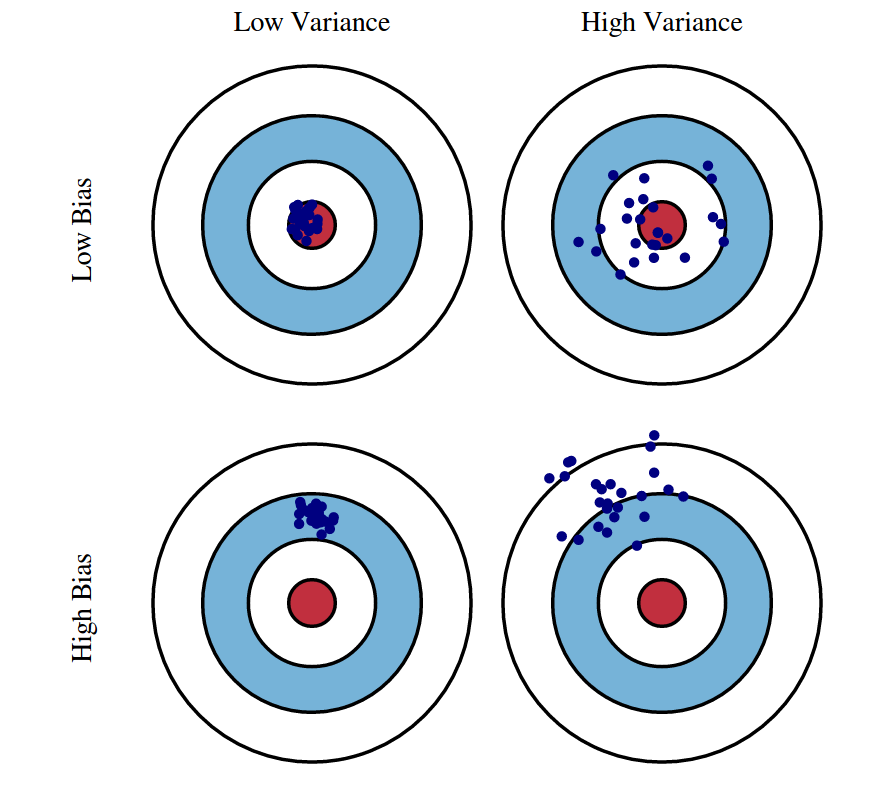

### **The Bias Variance Trade-Off**
The issue with using a learned value function to reduce the variance of the policy gradient estimate is that this function introduces bias simply because it isn't the true value function, it is an approximation and any errors in this approximation introduce bias. This trade-off is made in all RL algorithms, we will discuss in a later section how we can better balance bias and variance. For A2C we will use the high bias, low variance TD error.

$$\hat A_t = r_t + \gamma V(s_{t+1}) - V(s_t)$$

### **Why Bootstrapping Reduces Variance**
**Monte Carlo returns** depend on the entire sequence of future events in an episode. The final return $G_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} \dots$ is the sum of many random variables: every action taken and every resulting state and reward until the episode ends. This accumulation of many random outcomes creates high variance.

**The TD target** ($r_t + \gamma V(s_{t+1})$) depends on only one random event: the outcome of the very next step (the reward $r_t$ and next state $s_{t+1}$). Everything that happens after that is summarized by the learned value estimate $V(s_{t+1})$, which is a single, stable prediction. Because it only includes one step of real-world randomness, its value is far more consistent from one moment to the next.

In short, MC sums up a long sequence of random events, while TD uses just one random event plus a stable estimate. Fewer random variables result in lower variance.

## 4. Implementing A2C

### ✏️ **Exercise: Updating the REINFORCE Policy Network for A2C**

See if you can complete the ActorCriticNetwork class below.

In Actor-Critic methods, we use a single network that performs two roles. It has shared layers for general feature extraction which then split into two specialized "heads":



1.   An **Actor Head** that outputs action logits for action selection. (**This part is already complete for you**).
2.   A **Critic Head** that outputs a single state-value estimate, V(s), to estimate the value of the current state.


Your task is to **add the critic head to the network**. To do this, your __call__ function must:

1. Take the final hidden features from the shared layers and pass them through a new Dense layer to produce a single scalar value. This will be your critic_value.
2. Update the function to return both the existing actor_logits and your new critic_value.
3. **Hint:** Remember to use jnp.squeeze() on the critic's output to ensure it's a scalar value (e.g., shape ()) rather than a vector with one element (e.g., shape (1,)).

In [ ]:
class ActorCriticNetwork(nn.Module):
    """An actor-critic network that shares the initial layers."""
    @nn.compact
    def __call__(self, observation):
        # Shared layers (already complete)
        hidden = nn.Dense(64)(observation.flatten())
        hidden = nn.relu(hidden)
        hidden = nn.Dense(64)(hidden)
        hidden = nn.relu(hidden)

        # Actor head (policy - already complete)
        actor_logits = nn.Dense(num_actions)(hidden)

        # --- YOUR CODE HERE ---

        # 1. Create the critic head: a Dense layer that outputs a single value for the state-value estimate.
        critic_value = # ...

        # 2. Return both the actor's logits and the critic's value.
        # Don't forget to squeeze the critic's output to make it a scalar!
        return actor_logits, # ...

SyntaxError: invalid syntax (ipython-input-604483335.py, line 17)

In [ ]:
#@title Check Exercise (run me)
print("Running network test...")
try:
    # 1. Instantiate the network and create dummy data
    ac_network_test = ActorCriticNetwork()
    dummy_obs_test = jnp.ones(observation_shape)
    key, test_key = jax.random.split(key)

    # 2. Initialize parameters
    test_params = ac_network_test.init(test_key, dummy_obs_test)

    # 3. Get the outputs from the network
    logits_out, value_out = ac_network_test.apply(test_params, dummy_obs_test)

    # 4. Check the output shapes are correct
    assert logits_out.shape == (num_actions,), f"Logits shape is wrong! Expected {(num_actions,)}, but got {logits_out.shape}"
    assert value_out.shape == (), f"Critic value should be a scalar! Expected shape (), but got {value_out.shape}"

    print("✅ Success! Your `ActorCriticNetwork` returns two outputs with the correct shapes.")
    print(f"   - Logits output shape: {logits_out.shape}")
    print(f"   - Value output shape: {value_out.shape}")

except Exception as e:
    print("\n❌ Oops! An error occurred. Read the message below and check your network implementation.")
    print(f"   Error: {e}")
    print("\n   Common mistakes to check:")
    print("   - Did you return two items from the `__call__` method?")
    print("   - Did you remember to use `jnp.squeeze()` on the critic's output?")

Running network test...
✅ Success! Your `ActorCriticNetwork` returns two outputs with the correct shapes.
   - Logits output shape: (4,)
   - Value output shape: ()


In [ ]:
#@title Answer to Exercise (run me)

# 2. Create Actor-Critic Network
class ActorCriticNetwork(nn.Module):
    """An actor-critic network that shares the initial layers."""
    @nn.compact
    def __call__(self, observation):
        # Shared layers
        hidden = nn.Dense(64)(observation.flatten()) # Flatten the grid observation
        hidden = nn.relu(hidden)
        hidden = nn.Dense(64)(hidden)
        hidden = nn.relu(hidden)

        # Actor head (policy)
        actor_logits = nn.Dense(num_actions)(hidden)

        # Critic head (value)
        critic_value = nn.Dense(1)(hidden)

        return actor_logits, jnp.squeeze(critic_value)

### ✏️ **Exercise: A2C Objective**



See if you can **complete the a2c_loss_fn** below.

The goal here is to **move away from the high-variance "discounted return**" used in REINFORCE. Instead, we'll **use our critic's estimates to create a more stable, one-step "advantage" signal**. To do this, your loss function must perform three key calculations:



1.   **First, calculate the TD Target (r+γV(s′)):** You must compute the one-step target for the critic. This represents what the critic should have predicted for the current state. It's calculated by taking the immediate reward and adding the discounted value of the next state (next_values), which our critic provides.
2.   **Second, calculate the Critic Loss:** You must then train the critic to get better at its job. The critic's loss is how far its prediction (values) was from the target_values you just calculated. We use the mean squared error for this.
3. **Third, calculate the Advantage:** Finally, you'll compute the advantage for the actor. This is simply the difference between the target_values and what the critic actually predicted (values). This signal tells the actor whether the result of its action was better or worse than expected.

**Hint:** When calculating the advantage, it's crucial to wrap the calculation in jax.lax.stop_gradient. This treats the critic's output as a fixed constant and prevents the actor's training signals from interfering with the critic's training.

In [ ]:
def a2c_loss_fn(params, observations, actions, rewards, next_observations, dones):
    """Calculates the combined actor-critic loss."""

    # Get network outputs for the collected experience (already complete)
    # We use vmap to efficiently process the entire batch of transitions
    logits, values = jax.vmap(ac_network.apply, in_axes=(None, 0))(params, observations)
    _, next_values = jax.vmap(ac_network.apply, in_axes=(None, 0))(params, next_observations)

    # If the episode terminated, the value of the next state is 0 (already complete)
    next_values = next_values * (1 - dones)

    # --- YOUR CODE HERE ---

    # 1. Calculate the TD Target for the critic.
    #    This is the immediate reward plus the discounted value of the *next* state.
    target_values = # ...

    # 2. Calculate the critic's loss.
    #    This is the mean squared error between the `target_values` and the critic's actual output `values`.
    #    A 0.5 factor is common practice.
    critic_loss = # ...

    # 3. Calculate the advantage for the actor.
    #    Use jax.lax.stop_gradient on the target_values to prevent gradients from flowing into the critic from the actor loss.
    advantages = # ...

    # --- End of your code ---


    # Actor loss (policy gradient) (already complete)
    log_probs = nn.log_softmax(logits)
    action_log_probs = jax.vmap(lambda lp, a: lp[a])(log_probs, actions)
    actor_loss = -jnp.mean(action_log_probs * advantages)

    # Total loss is the sum of the actor and critic losses (already complete)
    total_loss = actor_loss + critic_loss
    return total_loss

SyntaxError: invalid syntax (ipython-input-66493210.py, line 16)

In [ ]:
#@title Check Exercise (run me)

# This cell will test your a2c_loss_fn implementation
print("Running loss function test...")

try:
    # 1. Create a dummy batch of data (batch size = 2)
    batch_size = 2
    dummy_obs_batch = jnp.ones((batch_size,) + observation_shape)
    dummy_next_obs_batch = jnp.ones((batch_size,) + observation_shape)
    dummy_actions_batch = jnp.array([0, 1])
    dummy_rewards_batch = jnp.array([1.0, -1.0])
    dummy_dones_batch = jnp.array([0.0, 1.0]) # First transition is non-terminal, second is terminal

    # 2. Calculate the loss
    loss_value = a2c_loss_fn(
        params,
        dummy_obs_batch,
        dummy_actions_batch,
        dummy_rewards_batch,
        dummy_next_obs_batch,
        dummy_dones_batch
    )

    # 3. Check that the loss is a scalar
    assert loss_value.shape == (), f"Loss should be a scalar! Expected shape (), but got {loss_value.shape}"

    # 4. Check that gradients can be computed
    grads = jax.grad(a2c_loss_fn)(
        params,
        dummy_obs_batch,
        dummy_actions_batch,
        dummy_rewards_batch,
        dummy_next_obs_batch,
        dummy_dones_batch
    )
    assert grads is not None, "Gradients could not be computed."

    print("✅ Success! Your `a2c_loss_fn` runs, returns a scalar, and is differentiable.")
    print(f"   - Calculated loss value on dummy data: {loss_value:.4f}")

except Exception as e:
    print("\n❌ Oops! An error occurred. Read the message below and check your loss function implementation.")
    print(f"   Error: {e}")
    print("\n   Common mistakes to check:")
    print("   - Are all your calculations using JAX numpy (`jnp`)?")
    print("   - Does your advantage calculation use `jax.lax.stop_gradient`?")

Running loss function test...

❌ Oops! An error occurred. Read the message below and check your loss function implementation.
   Error: name 'ac_network' is not defined

   Common mistakes to check:
   - Are all your calculations using JAX numpy (`jnp`)?
   - Does your advantage calculation use `jax.lax.stop_gradient`?


In [ ]:
#@title Answer to Exercise (run me)

def a2c_loss_fn(params, observations, actions, rewards, next_observations, dones):
    """Calculates the combined actor-critic loss."""

    # Get network outputs for the collected experience (already complete)
    # We use vmap to efficiently process the entire batch of transitions
    logits, values = jax.vmap(ac_network.apply, in_axes=(None, 0))(params, observations)
    _, next_values = jax.vmap(ac_network.apply, in_axes=(None, 0))(params, next_observations)

    # If the episode terminated, the value of the next state is 0 (already complete)
    next_values = next_values * (1 - dones)

    # --- SOLUTION ---

    # 1. Calculate the TD Target for the critic.
    #    This is the immediate reward plus the discounted value of the *next* state.
    target_values = rewards + gamma * next_values

    # 2. Calculate the critic's loss.
    #    This is the mean squared error between the `target_values` and the critic's actual output `values`.
    #    A 0.5 factor is common practice.
    critic_loss = 0.5 * jnp.mean((target_values - values) ** 2)

    # 3. Calculate the advantage for the actor.
    #    Use jax.lax.stop_gradient to treat the advantage calculation as a constant for the actor loss.
    advantages = jax.lax.stop_gradient(target_values - values)

    # --- End of solution ---


    # Actor loss (policy gradient) (already complete)
    log_probs = nn.log_softmax(logits)
    action_log_probs = jax.vmap(lambda lp, a: lp[a])(log_probs, actions)
    actor_loss = -jnp.mean(action_log_probs * advantages)

    # Total loss is the sum of the actor and critic losses (already complete)
    total_loss = actor_loss + critic_loss
    return total_loss

### **Training A2C**

It's time to put everything together! This final section contains the main training loop where the agent interacts with the environment and actually learns.

The code combines the ActorCriticNetwork and the a2c_loss_fn you worked on. The process for each episode follows a simple but powerful pattern:



1.   **Collect a Batch of Experiences:**  The agent interacts with the environment and stores its recent (observation, action, reward, next_observation, done) transitions in a temporary buffer.
2.   **Train the Network with Bootstrapping:** Once the temporary buffer fills up, the entire batch of fresh experiences is fed into our JIT-compiled train_step function to update the network.
This works because of **bootstrapping**. The agent doesn't need to wait for the game to end to learn. Instead, it combines the **immediate reward** it just received with its own **educated guess** about the value of the next state. The optimizer uses this information to adjust the network's parameters, allowing the agent to improve its strategy on-the-go.
3. **Reset the Buffer:** After the network is updated, the buffer is cleared. This is critical because it ensures the agent is always training on fresh data generated by its most recent policy.

This "act, collect, train" cycle repeats for many episodes, allowing the agent to gradually improve its snake-playing policy by learning from its successes and failures.

In [ ]:
# 3. Training Setup
learning_rate = 3e-4
gamma = 0.99
total_num_episodes = 20
update_threshold = 64 # The number of transitions to collect before an update

# Initialize the network and optimizer
ac_network = ActorCriticNetwork()
dummy_obs = jnp.ones(observation_shape)
key, network_init_key = jax.random.split(key)
params = ac_network.init(network_init_key, dummy_obs)

optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

@jax.jit
def train_step(params, opt_state, observations, actions, rewards, next_observations, dones):
    """Performs a single training update."""

    # Compute loss and gradients simultaneously, passing all required data to the loss function.
    loss, grads = jax.value_and_grad(a2c_loss_fn)(
        params,
        observations,
        actions,
        rewards,
        next_observations,
        dones
    )

    # Update parameters
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)

    return new_params, new_opt_state, loss

obs_buffer, act_buffer, rew_buffer, next_obs_buffer, done_buffer = [], [], [], [], []

# 4. Agent-Environment Interaction and Training Loop
for episode in range(total_num_episodes):
    obs, info = env.reset()
    done = False
    episode_return = 0

    while not done:
        grid_obs = obs['grid']
        key, action_key = jax.random.split(key)

        # Get action from the current policy
        logits, _ = ac_network.apply(params, grid_obs)
        masked_logits = mask_illegal_actions(logits, obs['action_mask'])
        action = select_action(masked_logits, action_key)

        # Step the environment
        next_obs, reward, done, info = env.step(action.item())
        grid_next_obs = next_obs['grid']

        # Add the new, on-policy transition to the temporary buffer
        obs_buffer.append(grid_obs)
        act_buffer.append(action)
        rew_buffer.append(reward)
        next_obs_buffer.append(grid_next_obs)
        done_buffer.append(done)

        episode_return += reward
        obs = next_obs

        # Train and reset the buffer if the threshold is reached
        if len(obs_buffer) == update_threshold:
            # Prepare the batch of on-policy data
            obs_b = jnp.array(obs_buffer)
            act_b = jnp.array(act_buffer)
            rew_b = jnp.array(rew_buffer)
            next_obs_b = jnp.array(next_obs_buffer)
            done_b = jnp.array(done_buffer)

            # Perform a training step
            params, opt_state, loss = train_step(params, opt_state, obs_b, act_b, rew_b, next_obs_b, done_b)

            # Reset the buffer to ensure only fresh data is used for the next update
            obs_buffer, act_buffer, rew_buffer, next_obs_buffer, done_buffer = [], [], [], [], []

    if episode % 1 == 0:
        print(f"Episode {episode} | Return: {episode_return:<4}")

Episode 0 | Return: 6.0 
Episode 1 | Return: 11.0
Episode 2 | Return: 7.0 
Episode 3 | Return: 4.0 
Episode 4 | Return: 4.0 
Episode 5 | Return: 13.0
Episode 6 | Return: 14.0
Episode 7 | Return: 12.0
Episode 8 | Return: 8.0 
Episode 9 | Return: 7.0 
Episode 10 | Return: 4.0 
Episode 11 | Return: 5.0 
Episode 12 | Return: 5.0 
Episode 13 | Return: 7.0 
Episode 14 | Return: 8.0 
Episode 15 | Return: 14.0
Episode 16 | Return: 5.0 
Episode 17 | Return: 4.0 
Episode 18 | Return: 10.0
Episode 19 | Return: 4.0 


In [ ]:
# @title Render the trained agent
frames = []
obs, _ = env.reset()
frames.append(env._state)

done = False

while not done:
  grid_obs = obs['grid']
  logits, _ = ac_network.apply(params, grid_obs)
  masked_logits = mask_illegal_actions(logits, obs['action_mask'])
  key, action_key = jax.random.split(key)
  action = select_action(masked_logits, action_key)
  obs, reward, done, info = env.step(action)
  frames.append(env._state)

env._env.animate(frames)

## 5. Generalised Advantage Estimation (GAE)

The problem with bootstrapping is that it results in a low variance, but high bias estimate (it puts us in the bottom left quadrant of the bias-variance trade-off image). This can lead to suboptimal policies. However, using Monte-Carlo rollouts (as we did in reinforce) has a high variance and can also lead to sub-optimal results (top right of the bias-variance trade-off image). The solution here is to find a balance between bootstrapping and Monte-Carlo rollouts and luckily an algorithm for this already exists: Generalised Advantages Estimation (GAE)!

**GAE** uses a single parameter $\lambda$ to control the bias-variance trade-off, where:
* $\lambda=1$ is equivalent to Monte-Carlo returns
* $\lambda=0$ is equivalent to bootstrapping
* $\lambda=0.95$ is a good value in general

We will use GAE in our next practical where we will implement Proximal Policy Optimisation (PPO).

## The Math and Code Behind GAE (optional)

### **n-step TD Error**
Remember that at the end of the bootstrapping section we discussed that the TD Error isn't perfect. It reduces the variance of the policy gradient estimate, but it introduces a bias because the learned value function is not the true value function, but rather an approximation.

As a reminder the **1-step TD Error** on step $t$ is defined as:
$$ \hat A_t = r_t + \gamma V(s_{t+1}) - V(s_t) $$

This is called the **1-step**  TD Error because it only considers a single real reward before bootstrapping. We can also define an n-step advantage, $\hat A^{(n)}_t$, which incorporates $n$ real rewards before using the value function:

$$ \hat A^{(1)}_t = r_t + \gamma V(s_{t+1}) - V(s_t) $$
$$ \hat A^{(2)}_t = r_t + \gamma r_{t+1} + \gamma^2 V(s_{t+2}) - V(s_t) $$
$$ \hat A^{(3)}_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \gamma^3 V(s_{t+3}) - V(s_t) $$

$$ \hat A^{(n)}_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \ldots + \gamma^n V(s_{t+n}) - V(s_t)$$

As $n$ increases, the number of real rewards in the estimate grows, while the discounted value function term $\gamma^nV(s_{t+n​})$ has less impact. This means that as $n \rightarrow \infty$, the bias of our advantage estimate decreases, but the variance increases because we are summing more random rewards.

### $\mathbf{GAE(\gamma, \lambda)}$
The Generalized Advantage Estimator $GAE(\gamma, \lambda)$ provides an elegant way to compromise between these different n-step estimates. It's defined as the exponentially-weighted average of all of them:

$$ \hat A_t^{GAE} = (1 - \lambda)(\hat A^{(1)}_t + \lambda \hat A^{(2)}_t + \lambda^2 \hat A^{(3)}_t + \ldots) $$

To better understand this we can first assign our 1-step TD error to $\delta^V_t$ instead of $\hat A_t$ for clarity:

$$ \delta^V_t = r_t + \gamma V(s_{t+1}) - V(s_t) $$

Then we can rewrite $GAE(\gamma, \lambda)$ in term of $\delta^V_t$:

$$ \hat A_t^{GAE} = \sum_{i=0}^{\infty} (\gamma \lambda)^l \delta^V_{t+i} = \delta^V_t + \gamma \lambda \delta^V_{t+1} + \gamma^2 \lambda^2 \delta^V_{t+2} + \ldots $$

Now we can more easily understand GAE. We can see that the advantage is the *surprise* (TD error) we see at the current step, plus a discounted measure of all future surprises. If our value function is perfect, all TD errors are zero, and the advantage is zero. If an action leads to a positive surprise ($\delta^V_t > 0$), it contributes positively to the advantage. This formulation shows how GAE elegantly propagates credit from future outcomes back to the current action.

### **The Role of Lambda (λ)**

The hyperparameter λ (lambda), which is between 0 and 1, is the key to controlling the bias-variance trade-off. It acts as a mixing knob:

**If λ=0:** The formula collapses to just $\hat A_t^{GAE}​=A_t^{(1)}$​. We get the 1-step TD Error, which has high bias (due to its heavy reliance on V(st+1​)) but low variance (as it only includes one random reward, rt​). This is the advantage estimate used in A2C.

**If λ=1:** The formula becomes an infinite sum of n-step returns. This effectively cancels out all the intermediate value function estimates, resulting in the Monte Carlo return. This has low bias but high variance and is used in REINFORCE.

**If $\mathbf{0 < \lambda < 1}$**: We get a blend of all n-step advantages. The weights for longer-term advantages decay exponentially, controlled by λ. This allows us to find a sweet spot, reducing variance without introducing too much bias. A common default value that works well in practice is λ=0.95.

### **How to code GAE**

Calculating an infinite sum is impossible. However, we can compute GAE efficiently using the recursive relationship from the formula above. Notice that:

$$ \hat A_t^{GAE} = \sum_{i=0}^{\infty} (\gamma \lambda)^l \delta^V_{t+i} = \delta^V_t + \gamma \lambda \delta^V_{t+1} + \gamma^2 \lambda^2 \delta^V_{t+2} + \ldots $$

This gives us a practical algorithm. For a trajectory of length $T$:


1.   Collect a trajectory: Run the policy to get a sequence of states, rewards, and value estimates: $(s_0, r_0, v_0), (s_1, r_1, v_1), \ldots, (s_{T-1}, v_{T-1}, r_{T-1})$. You also need one final value estimate for the state after the last action, $V(s_T)$.

2.   Calculate all TD errors: For each step $t$ from $0$ to $T - 1$, compute $\delta^V_t = r_t + \gamma V(s_t+1) - V(s_t)$. If a state $s_t$ is terminal, then $V(s_{t+1})$ is treated as $0$.
3.   Iterate backwards: To calculate the advantages, start from the end of the trajectory and work backwards. The advantage at the last step, $A_{T-1}$, is just its TD error: $\delta^V_{T-1}$ (since $A_T=0$). And the advantage of all other steps is it's TD Error plus the discounted (by $\gamma$ and $\lambda$) error of the next step:

$$ \delta^V_t + \gamma \lambda \hat A_{t+1} $$

We iterate backwards because the advantage at step $t$ depends on the advantage at step $t+1$. This simple loop efficiently calculates the GAE for every step in the trajectory, giving us a stable, low-variance target for updating our policy.

### ✏️ **Exercise write the GAE function:**

In [ ]:
import numpy as np

def calculate_gae(
  rewards: np.ndarray,  # shape: (T,)
  values: np.ndarray,   # shape: (T+1,) this contains the final value V_{t+1}
  dones: np.ndarray,    # shape: (T,)
  gamma: float = 0.99,  # shape: (1,)
  gae_lambda: float = 0.95, # shape: (1,)
):
    """
    Calculates the Generalized Advantage Estimation (GAE) for a trajectory.

    Returns:
        np.ndarray: The calculated advantages for each step in the trajectory.
    """
    num_steps = len(rewards)
    advantages = np.zeros_like(rewards, dtype=np.float32)
    next_advantage = 0.0

    # Iterate backwards from the last step to the first
    for t in reversed(range(num_steps)):
        # The mask is 0 if the state is terminal (done=True), and 1 otherwise.
        # This handles resetting the advantage calculation at episode boundaries.
        mask = ...

        # Calculate the TD error (delta) for the current step
        # delta_t = r_t + gamma * V(s_{t+1}) - V(s_t)
        # V(s_{t+1}) is masked to 0 if the episode ended.
        delta = ...

        # Calculate the advantage using the recursive GAE formula
        # A_t = delta_t + gamma * lambda * A_{t+1}
        # The advantage from the next step (next_advantage) is also masked.
        advantages[t] = ...

        # advantage is now next_advantage for our next go around the loop
        next_advantage = advantages[t]

    return advantages

In [ ]:
# @title Check Exercise (Run Me!)

rewards = np.array([1, 2, 3, 4, 5], dtype=float)
dones = np.array([False, False, True, False, False], dtype=bool)
values = np.array([13, 12, 11, 8, 3, 1], dtype=float)

advantages = calculate_gae(rewards, values, dones)

expected = np.array([-6.359277, -6.634, -8.0, 1.782095, 2.99])
if not np.allclose(advantages, expected):
  print(f"Your GAE function doesn't seem to be quite right, please try again.\nYour advantages: {advantages}\nExpected:        {expected}")
else:
  print("Well done, your advantage function is correct!")

In [ ]:
# @title Solution
import numpy as np

def calculate_gae(
  rewards: np.ndarray,  # shape: (T,)
  values: np.ndarray,   # shape: (T+1,) this contains the final value V_{t+1}
  dones: np.ndarray,    # shape: (T,)
  gamma: float = 0.99,  # shape: (1,)
  gae_lambda: float = 0.95, # shape: (1,)
):
    """
    Calculates the Generalized Advantage Estimation (GAE) for a trajectory.

    Returns:
        np.ndarray: The calculated advantages for each step in the trajectory.
    """
    num_steps = len(rewards)
    advantages = np.zeros_like(rewards, dtype=np.float32)
    next_advantage = 0.0

    # Iterate backwards from the last step to the first
    for t in reversed(range(num_steps)):
        # The mask is 0 if the state is terminal (done=True), and 1 otherwise.
        # This handles resetting the advantage calculation at episode boundaries.
        mask = 1.0 - dones[t]

        # Calculate the TD error (delta) for the current step
        # delta_t = r_t + gamma * V(s_{t+1}) - V(s_t)
        # V(s_{t+1}) is masked to 0 if the episode ended.
        delta = rewards[t] + gamma * values[t + 1] * mask - values[t]

        # Calculate the advantage using the recursive GAE formula
        # A_t = delta_t + gamma * lambda * A_{t+1}
        # The advantage from the next step (next_advantage) is also masked.
        advantages[t] = delta + gamma * gae_lambda * next_advantage * mask
        next_advantage = advantages[t]

    return advantages

## Conclusion

In this practical, we revisited the REINFORCE algorithm and delved into its limitations, specifically its high variance. We explored how subtracting a baseline can reduce this variance and introduced the concept of **advantage estimation**. Initially, we used a simple Monte Carlo average of returns as a baseline, observing how it can improve gradient stability.

We then moved on to the core of Actor-Critic methods by implementing a separate **Critic network** to learn a state-value function $V(s)$, which serves as a more sophisticated, state-dependent baseline. This led us to understand the concept of **bootstrapping**, where we use the learned value function to create a **Temporal Difference (TD) target** ($r_t + \gamma V(s_{t+1}))$ and the **TD error** as a low-variance estimate of the advantage ($\hat A_t = r_t + \gamma V(s_{t+1}) - V(s_t)$).

Finally, we implemented a basic **Advantage Actor-Critic (A2C)** agent that utilizes this bootstrapped advantage to update both the actor (policy) and the critic (value function) simultaneously. This approach allows for more frequent updates and can lead to more stable training compared to vanilla REINFORCE. We also touched upon **Generalised Advantage Estimation (GAE)** as a way to balance the bias-variance trade-off introduced by bootstrapping, a concept we will explore further in the next practical with Proximal Policy Optimization (PPO).

## Resources for further learning
If this practical piqued your interest and you would like to learn more, the following references will help you on your way!

- The most infuential textbook on RL - [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html).
- [David Silver's RL course](https://www.youtube.com/playlist?list=PLzuuYNsE1EZAXYR4FJ75jcJseBmo4KQ9-).
- For more on policy gradient methods, you can view:
  - The 2022 [Deep Learning Indaba RL prac](https://github.com/deep-learning-indaba/indaba-pracs-2022/blob/main/practicals/introduction_to_reinforcement_learning.ipynb)
  - [Spinning Up in RL - Intro to Policy Optimization](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html) or
  - [Lilian Weng's Blog - Policy Gradient Algorithms](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/)
- [Hugging Face's Deep RL course](https://huggingface.co/learn/deep-rl-course/en/unit0/introduction)
- [More practicals from the Deep Learning Indaba](https://github.com/deep-learning-indaba)
- [CleanRL's clean implementations of popular Deep RL algorithms](https://github.com/vwxyzjn/cleanrl)

## Feedback

Please fill out this form as it is a very important part of the practicals. Your feedback will help us **improve the practicals and will also count towards the prize at the end of the sessions!**

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/Ehidzyxs8pYoT1eZ9",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

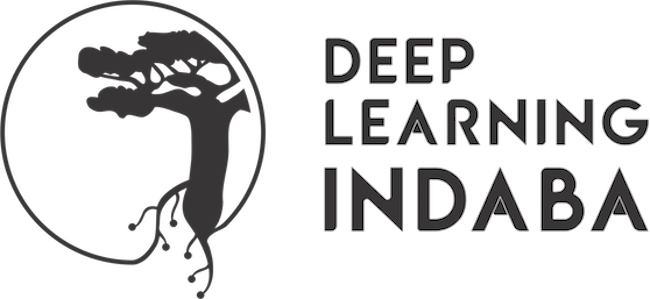